In [66]:
import pandas as pd
import numpy as np

In [67]:
gini = pd.read_csv('API_SI.POV.GINI_DS2_en_csv_v2_296215.csv')
gini.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,51.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# Drop the 'Unnamed: 69' column if it exists and is irrelevant
if 'Unnamed: 69' in gini.columns:
    gini = gini.drop(columns=['Unnamed: 69'])

# Identify the columns that represent years (they are numeric strings)
year_columns = [col for col in gini.columns if col.isdigit() ]

# Identify the identifier columns
id_vars = [col for col in gini.columns if col not in year_columns]

# Melt the DataFrame to transform year columns into rows
gini_tidy = gini.melt(id_vars=id_vars, value_vars=year_columns, var_name='year', value_name='gini_value')

# Convert 'year' column to integer type
gini_tidy['year'] = pd.to_numeric(gini_tidy['year'])

# Display the head of the tidied DataFrame
display(gini_tidy.head())

,Country Name,Country Code,Indicator Name,Indicator Code,year,gini_value
0,Aruba,ABW,Gini index,SI.POV.GINI,1960,NaN
1,Africa Eastern and Southern,AFE,Gini index,SI.POV.GINI,1960,NaN
2,Afghanistan,AFG,Gini index,SI.POV.GINI,1960,NaN
3,Africa Western and Central,AFW,Gini index,SI.POV.GINI,1960,NaN
4,Angola,AGO,Gini index,SI.POV.GINI,1960,NaN


The `gini_tidy` DataFrame now has a 'year' column, making it easier to analyze time-series data for Gini index values.

In [69]:
# Filter out rows with NaN gini_value
gini_no_nan = gini_tidy.dropna(subset=['gini_value'])

# Find the highest year for each country and use it to filter
gini_plot_data = gini_no_nan.loc[gini_no_nan.groupby('Country Name')['year'].idxmax()]

print(f"Data for the highest available year per country:")
print(gini_plot_data.shape)
gini_plot_data.head()

Data for the highest available year per country:
(171, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,year,gini_value
15965,Albania,ALB,Gini index,SI.POV.GINI,2020,29.4
13626,Algeria,DZA,Gini index,SI.POV.GINI,2011,27.6
15432,Angola,AGO,Gini index,SI.POV.GINI,2018,51.3
17033,Argentina,ARG,Gini index,SI.POV.GINI,2024,42.4
16768,Armenia,ARM,Gini index,SI.POV.GINI,2023,27.2


In [70]:
gini_plot_data.gini_value.min(), gini_plot_data.gini_value.max()

(np.float64(23.8), np.float64(63.0))

In [71]:
import plotly.express as px

# Create the choropleth map for gini value of country
fig = px.choropleth(
    gini_plot_data,
    locations='Country Code',
    color='gini_value',
    hover_name='Country Name',
    color_continuous_scale='spectral_r', # Changed colorscale to blue-to-red
    range_color=[20, 60],
    title='LatestGlobal Gini Index (Blue to Red: 20 to 60)',
    projection='natural earth'
)

fig.show()

In [72]:
from pandas_datareader import data, wb

start_year = 1990
end_year = 2024
countries = ['USA','IND','CHN','BRA','ZAF', 'NLD']  # ISO3 codes accepted
# Indicators dictionary
indicators = {
    'NY.GDP.PCAP.KD': 'gdp_percap_const',
    'SL.UEM.TOTL.ZS': 'unemployment_pct',
    'FP.CPI.TOTL.ZG': 'inflation_pct',
    # 'SE.XPD.TOTL.GD.ZS': 'edu_spend_pct_gdp',
    'NE.TRD.GNFS.ZS': 'trade_pct_gdp',
    'SP.POP.TOTL': 'population'
}

from functools import reduce
frames = []
for code, name in indicators.items():
    print('Downloading', code)
    try:
        # Use wb.download, which is more robust for World Bank data and accepts 'country'
        df = wb.download(indicator=code, country=countries, start=start_year, end=end_year)
        df = df.reset_index() # country and year become columns

        # Rename columns: the indicator code to its friendly name, and 'country' to 'country_name'
        df = df.rename(columns={'country': 'country_name', code: name})

        frames.append(df[['country_name','year', name]])
    except Exception as e:
        print('Failed to fetch', code, ' — ', e)

if frames:
    indicators_df = reduce(lambda left, right: pd.merge(left, right, on=['country_name','year'], how='outer'), frames)
else:
    raise RuntimeError('No data frames fetched. Please download CSVs manually.')

indicators_df.sort_values(['country_name','year'], inplace=True)

/var/folders/nf/h6pl836x6_39vqhbwflhx77w0000gn/T/ipykernel_90943/3255671260.py:22: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

/var/folders/nf/h6pl836x6_39vqhbwflhx77w0000gn/T/ipykernel_90943/3255671260.py:22: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



/var/folders/nf/h6pl836x6_39vqhbwflhx77w0000gn/T/ipykernel_90943/3255671260.py:22: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

/var/folders/nf/h6pl836x6_39vqhbwflhx77w0000gn/T/ipykernel_90943/3255671260.py:22: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



/var/folders/nf/h6pl836x6_39vqhbwflhx77w0000gn/T/ipykernel_90943/3255671260.py:22: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [73]:
indicators_df['year'] = pd.to_numeric(indicators_df['year'])
print(indicators_df.shape)
indicators_df.head()

(210, 7)


,country_name,year,gdp_percap_const,unemployment_pct,inflation_pct,trade_pct_gdp,population
0,Brazil,1990,6149.867889,NaN,2947.732772,15.155599,149143223
1,Brazil,1991,6107.648837,6.894,432.786662,16.592078,151724256
2,Brazil,1992,5973.982856,7.086,951.962053,19.253375,154275079
3,Brazil,1993,6167.460922,6.030,1927.380790,19.599321,156794577
4,Brazil,1994,6427.169019,6.578,2075.888398,18.674760,159265006


In [74]:
indicators_df.year.unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024])

---
# Inequality Data

In [75]:
ind_df = pd.read_csv("WID_data_IN.csv", sep=";")
bzl_df = pd.read_csv("WID_data_BR.csv", sep=";")
usa_df = pd.read_csv("WID_data_US.csv", sep=";")
chn_df = pd.read_csv("WID_data_CN.csv", sep=";")
nld_df = pd.read_csv("WID_data_NL.csv", sep=";")
saf_df = pd.read_csv("WID_data_ZA.csv", sep=";")

print(f"Shape of India DataFrame: {ind_df.shape}")
print(f"Shape of Brazil DataFrame: {bzl_df.shape}")
print(f"Shape of USA DataFrame: {usa_df.shape}")
print(f"Shape of China DataFrame: {chn_df.shape}")
print(f"Shape of Netherlands DataFrame: {nld_df.shape}")
print(f"Shape of South Africa DataFrame: {saf_df.shape}")

Shape of India DataFrame: (734991, 7)
Shape of Brazil DataFrame: (543551, 7)
Shape of USA DataFrame: (1215596, 7)
Shape of China DataFrame: (580914, 7)
Shape of Netherlands DataFrame: (757711, 7)
Shape of South Africa DataFrame: (930128, 7)


WID variable codes follow a structured format:

- **s** → Share (the variable measures a share of income/wealth).
- **ptinc** → Pretax income (income before taxes and transfers).
- **j** → Equal-split adults (income is split equally between partners in a household).
- **992 vs. 999** → Age group codes:
    - 992 = Adults only (age 20+)
    - 999 = All ages (entire population, including children)

In [76]:
ind_df['variable'].unique()
ind_df_filtered = ind_df[ind_df['variable'].str.lower().str.startswith("sptincj999")].reset_index(drop=True)
bzl_df_filtered = bzl_df[bzl_df['variable'].str.lower().str.startswith("sptincj999")].reset_index(drop=True)
usa_df_filtered = usa_df[usa_df['variable'].str.lower().str.startswith("sptincj999")].reset_index(drop=True)
chn_df_filtered = chn_df[chn_df['variable'].str.lower().str.startswith("sptincj999")].reset_index(drop=True)
nld_df_filtered = nld_df[nld_df['variable'].str.lower().str.startswith("sptincj999")].reset_index(drop=True)
saf_df_filtered = saf_df[saf_df['variable'].str.lower().str.startswith("sptincj999")].reset_index(drop=True)

print(f"Filtered Shape of India DataFrame: {ind_df_filtered.shape}")
print(f"Filtered Shape of Brazil DataFrame: {bzl_df_filtered.shape}")
print(f"Filtered Shape of USA DataFrame: {usa_df_filtered.shape}")
print(f"Filtered Shape of China DataFrame: {chn_df_filtered.shape}")
print(f"Filtered Shape of Netherlands DataFrame: {nld_df_filtered.shape}")
print(f"Filtered Shape of South Africa DataFrame: {saf_df_filtered.shape}")
df_combined = pd.concat([ind_df_filtered, bzl_df_filtered, usa_df_filtered, chn_df_filtered, nld_df_filtered, saf_df_filtered], ignore_index=True)
print(f"Combined DataFrame Shape: {df_combined.shape}")
print(f"Sample data from combined DataFrame:\n{df_combined.head(5)}")

Filtered Shape of India DataFrame: (32141, 7)
Filtered Shape of Brazil DataFrame: (21686, 7)
Filtered Shape of USA DataFrame: (45289, 7)
Filtered Shape of China DataFrame: (22457, 7)
Filtered Shape of Netherlands DataFrame: (21672, 7)
Filtered Shape of South Africa DataFrame: (21692, 7)
Combined DataFrame Shape: (164937, 7)
Sample data from combined DataFrame:
  country    variable percentile  year   value  age pop
0      IN  sptincj999     p4p100  1820  0.9911  999   j
1      IN  sptincj999     p4p100  1850  0.9922  999   j
2      IN  sptincj999     p4p100  1880  0.9982  999   j
3      IN  sptincj999     p4p100  1900  0.9982  999   j
4      IN  sptincj999     p4p100  1910  0.9919  999   j


In [77]:
df_combined[['p_start', 'p_end']] = df_combined['percentile'].str.extract(r'p(\d+\.?\d*)p(\d+\.?\d*)').astype("float")
df_combined.head()

,country,variable,percentile,year,value,age,pop,p_start,p_end
0,IN,sptincj999,p4p100,1820,0.9911,999,j,4.0,100.0
1,IN,sptincj999,p4p100,1850,0.9922,999,j,4.0,100.0
2,IN,sptincj999,p4p100,1880,0.9982,999,j,4.0,100.0
3,IN,sptincj999,p4p100,1900,0.9982,999,j,4.0,100.0
4,IN,sptincj999,p4p100,1910,0.9919,999,j,4.0,100.0


In [78]:
# Filtering top 10%, top 1%, top 0.1%, and bottom 50%
top_10 = df_combined[(df_combined['p_start'] == 90) & (df_combined['p_end'] == 100)].reset_index(drop=True)
top_1 = df_combined[(df_combined['p_start'] == 99) & (df_combined['p_end'] == 100)].reset_index(drop=True)
top_0_1 = df_combined[(df_combined['p_start'] == 99.9) & (df_combined['p_end'] == 100)].reset_index(drop=True)
bottom_50 = df_combined[(df_combined['p_start'] == 0) & (df_combined['p_end'] == 50)].reset_index(drop=True)

df_income_summary = pd.concat([top_10, top_1, top_0_1, bottom_50], ignore_index=True)
df_income_summary['income_distribution'] = np.where(df_income_summary['p_start'] == 90, 'top_10%',
                                        np.where(df_income_summary['p_start'] == 99, 'top_1%',
                                        np.where(df_income_summary['p_start'] == 99.9, 'top_0.1%',
                                        np.where(df_income_summary['p_start'] == 0, 'bottom_50%', 'other'))))
df_income_summary

,country,variable,percentile,year,value,age,pop,p_start,p_end,income_distribution
0,IN,sptincj999,p90p100,1820,0.4800,999,j,90.0,100.0,top_10%
1,IN,sptincj999,p90p100,1850,0.5000,999,j,90.0,100.0,top_10%
2,IN,sptincj999,p90p100,1880,0.5460,999,j,90.0,100.0,top_10%
3,IN,sptincj999,p90p100,1900,0.5376,999,j,90.0,100.0,top_10%
4,IN,sptincj999,p90p100,1910,0.4480,999,j,90.0,100.0,top_10%
...,...,...,...,...,...,...,...,...,...,...
1699,ZA,sptincj999,p0p50,2020,0.0627,999,j,0.0,50.0,bottom_50%
1700,ZA,sptincj999,p0p50,2021,0.0627,999,j,0.0,50.0,bottom_50%
1701,ZA,sptincj999,p0p50,2022,0.0627,999,j,0.0,50.0,bottom_50%
1702,ZA,sptincj999,p0p50,2023,0.0627,999,j,0.0,50.0,bottom_50%


In [79]:
df_wide = df_income_summary.pivot_table(
    index=['country','year'],
    columns='income_distribution',
    values='value'
).reset_index(drop=False)
df_wide

income_distribution,country,year,bottom_50%,top_0.1%,top_1%,top_10%
0,BR,1820,0.1173,0.0970,0.2348,0.5324
1,BR,1850,0.1159,0.0977,0.2373,0.5380
2,BR,1880,0.1145,0.0984,0.2397,0.5436
3,BR,1900,0.1131,0.0990,0.2422,0.5492
4,BR,1910,0.1103,0.1003,0.2472,0.5605
...,...,...,...,...,...,...
421,ZA,2020,0.0627,0.0574,0.1921,0.6508
422,ZA,2021,0.0627,0.0574,0.1921,0.6508
423,ZA,2022,0.0627,0.0574,0.1921,0.6508
424,ZA,2023,0.0627,0.0574,0.1921,0.6508


In [80]:
inequality_df = df_wide[(df_wide['year'] >= 1990) & (df_wide['year'] <= 2024)]
inequality_df.rename(columns={'country': 'country_code'}, inplace=True)
inequality_df.head(20)

/var/folders/nf/h6pl836x6_39vqhbwflhx77w0000gn/T/ipykernel_90943/4278397467.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



income_distribution,country_code,year,bottom_50%,top_0.1%,top_1%,top_10%
21,BR,1990,0.0912,0.1279,0.2724,0.5861
22,BR,1991,0.0912,0.1279,0.2724,0.5861
23,BR,1992,0.0912,0.1279,0.2724,0.5861
24,BR,1993,0.0912,0.1279,0.2724,0.5861
25,BR,1994,0.0912,0.1279,0.2724,0.5861
26,BR,1995,0.0912,0.1279,0.2724,0.5861
27,BR,1996,0.0912,0.1279,0.2724,0.5861
28,BR,1997,0.0912,0.1279,0.2724,0.5861
29,BR,1998,0.0912,0.1279,0.2724,0.5861
30,BR,1999,0.0912,0.1279,0.2724,0.5861


In [81]:
# #--------------FOR Checking countries Data ------------------------
# test_df = indicators_df[indicators_df['country_code'] == 'US']
# test_df.year = pd.to_numeric(test_df['year'])
# print(test_df.shape)
# test_df[:50]

In [82]:
country_name_to_code_map = {
    # 'Brazil': 'BR',
    'India': 'IN',
    'United States': 'US',
    'China': 'CN',
    'Netherlands': 'NL',
    'South Africa': 'ZA'
}
indicators_df.rename(columns={'country_name': 'country'}, inplace=True)
indicators_df['country_code'] = indicators_df['country'].replace(country_name_to_code_map)
print(indicators_df.shape)
indicators_df.head()

(210, 8)


,country,year,gdp_percap_const,unemployment_pct,inflation_pct,trade_pct_gdp,population,country_code
0,Brazil,1990,6149.867889,NaN,2947.732772,15.155599,149143223,Brazil
1,Brazil,1991,6107.648837,6.894,432.786662,16.592078,151724256,Brazil
2,Brazil,1992,5973.982856,7.086,951.962053,19.253375,154275079,Brazil
3,Brazil,1993,6167.460922,6.030,1927.380790,19.599321,156794577,Brazil
4,Brazil,1994,6427.169019,6.578,2075.888398,18.674760,159265006,Brazil


In [83]:
indicators_df.year.unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024])

In [84]:
indicators_df.country.unique()

array(['Brazil', 'China', 'India', 'Netherlands', 'South Africa',
       'United States'], dtype=object)

In [85]:
# Now attempt the merge again
df_merge = pd.merge(inequality_df, indicators_df, on=['country_code', 'year'])

# Print head of the merged dataframe to verify
print(df_merge.shape)
df_merge.head()

(175, 12)


,country_code,year,bottom_50%,top_0.1%,top_1%,top_10%,country,gdp_percap_const,unemployment_pct,inflation_pct,trade_pct_gdp,population
0,CN,1990,0.2146,0.0319,0.0821,0.3085,China,917.270662,NaN,NaN,24.225982,1135185000
1,CN,1991,0.2027,0.0328,0.0842,0.3150,China,989.548541,2.37,NaN,25.872981,1150780000
2,CN,1992,0.1939,0.0343,0.0885,0.3271,China,1117.273295,2.37,NaN,30.034094,1164970000
3,CN,1993,0.1849,0.0359,0.0929,0.3390,China,1258.349461,2.69,NaN,35.908642,1178440000
4,CN,1994,0.1811,0.0371,0.0954,0.3433,China,1406.858457,2.90,24.25699,35.605464,1191835000


In [86]:
df_merge.isna().sum()

country_code        0
year                0
bottom_50%          0
top_0.1%            0
top_1%              0
top_10%             0
country             0
gdp_percap_const    0
unemployment_pct    5
inflation_pct       4
trade_pct_gdp       0
population          0
dtype: int64

In [87]:
df_merge['inflation_pct'] = df_merge.groupby('country')['inflation_pct'].transform(lambda x: x.ffill().bfill())
df_merge['unemployment_pct'] = df_merge.groupby('country')['unemployment_pct'].transform(lambda x: x.ffill().bfill())
# df_merge['edu_spend_pct_gdp'] = df_merge.groupby('country')['edu_spend_pct_gdp'].transform(lambda x: x.ffill().bfill())
missing_inflation_pct_count = df_merge['inflation_pct'].isnull().sum()
print(f"Number of missing 'inflation_pct' values before filling: {missing_inflation_pct_count}")
print("Missing 'inflation_pct' values after filling:", df_merge['inflation_pct'].isnull().sum())

Number of missing 'inflation_pct' values before filling: 0
Missing 'inflation_pct' values after filling: 0


In [88]:
df_merge

,country_code,year,bottom_50%,top_0.1%,top_1%,top_10%,country,gdp_percap_const,unemployment_pct,inflation_pct,trade_pct_gdp,population
0,CN,1990,0.2146,0.0319,0.0821,0.3085,China,917.270662,2.370,24.256990,24.225982,1135185000
1,CN,1991,0.2027,0.0328,0.0842,0.3150,China,989.548541,2.370,24.256990,25.872981,1150780000
2,CN,1992,0.1939,0.0343,0.0885,0.3271,China,1117.273295,2.370,24.256990,30.034094,1164970000
3,CN,1993,0.1849,0.0359,0.0929,0.3390,China,1258.349461,2.690,24.256990,35.908642,1178440000
4,CN,1994,0.1811,0.0371,0.0954,0.3433,China,1406.858457,2.900,24.256990,35.605464,1191835000
...,...,...,...,...,...,...,...,...,...,...,...,...
170,ZA,2020,0.0627,0.0574,0.1921,0.6508,South Africa,5569.584833,29.217,3.232388,50.759659,60562381
171,ZA,2021,0.0627,0.0574,0.1921,0.6508,South Africa,5756.195494,34.007,4.618745,56.034714,61502603
172,ZA,2022,0.0627,0.0574,0.1921,0.6508,South Africa,5783.860904,33.268,7.039873,64.783002,62378410
173,ZA,2023,0.0627,0.0574,0.1921,0.6508,South Africa,5747.419650,32.098,6.075244,65.180096,63212384


In [89]:
df_merge.isna().sum()

country_code        0
year                0
bottom_50%          0
top_0.1%            0
top_1%              0
top_10%             0
country             0
gdp_percap_const    0
unemployment_pct    0
inflation_pct       0
trade_pct_gdp       0
population          0
dtype: int64

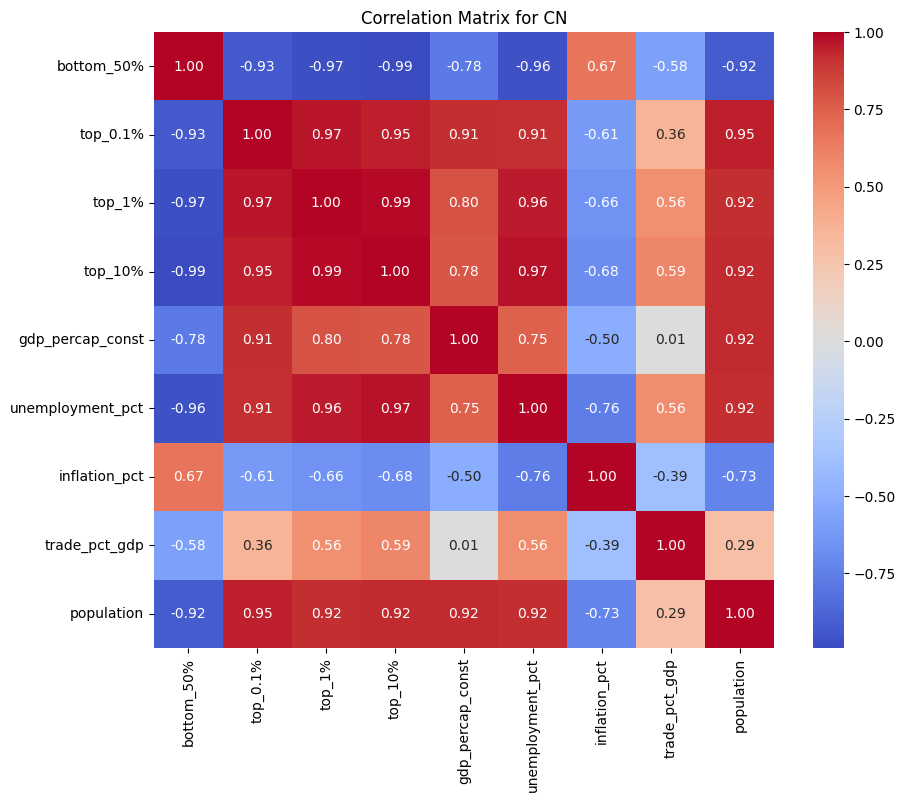

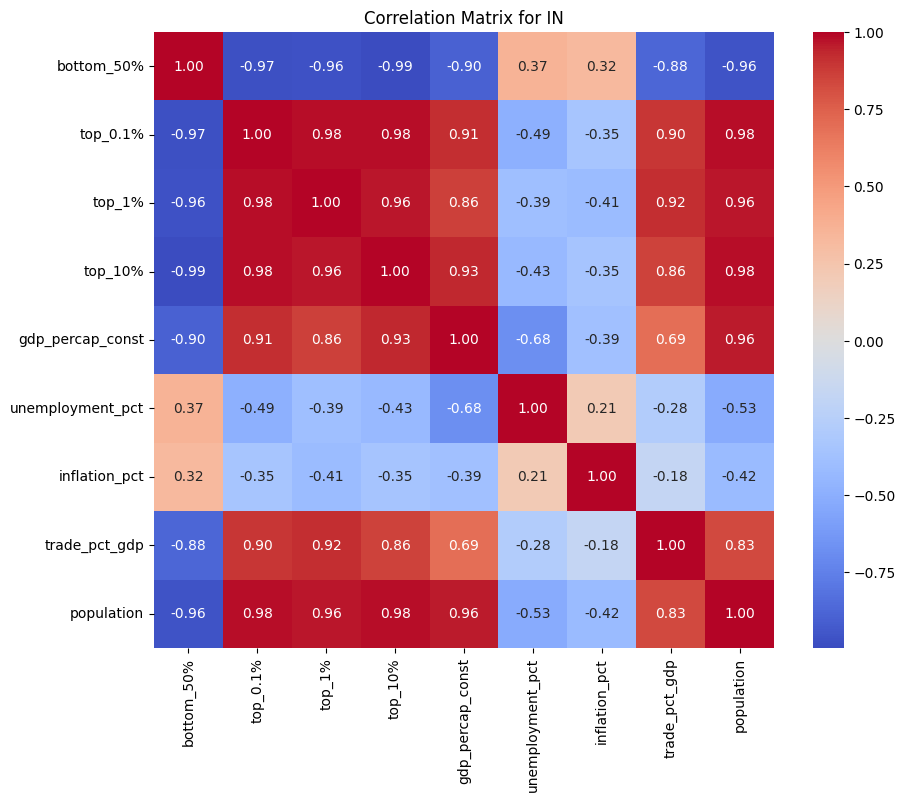

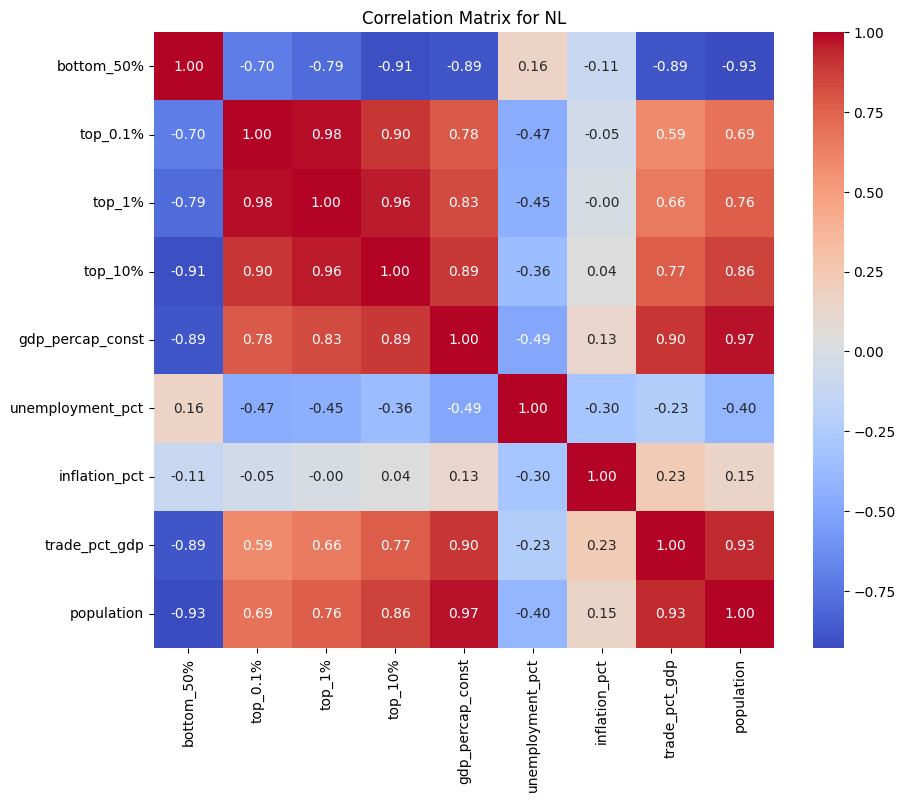

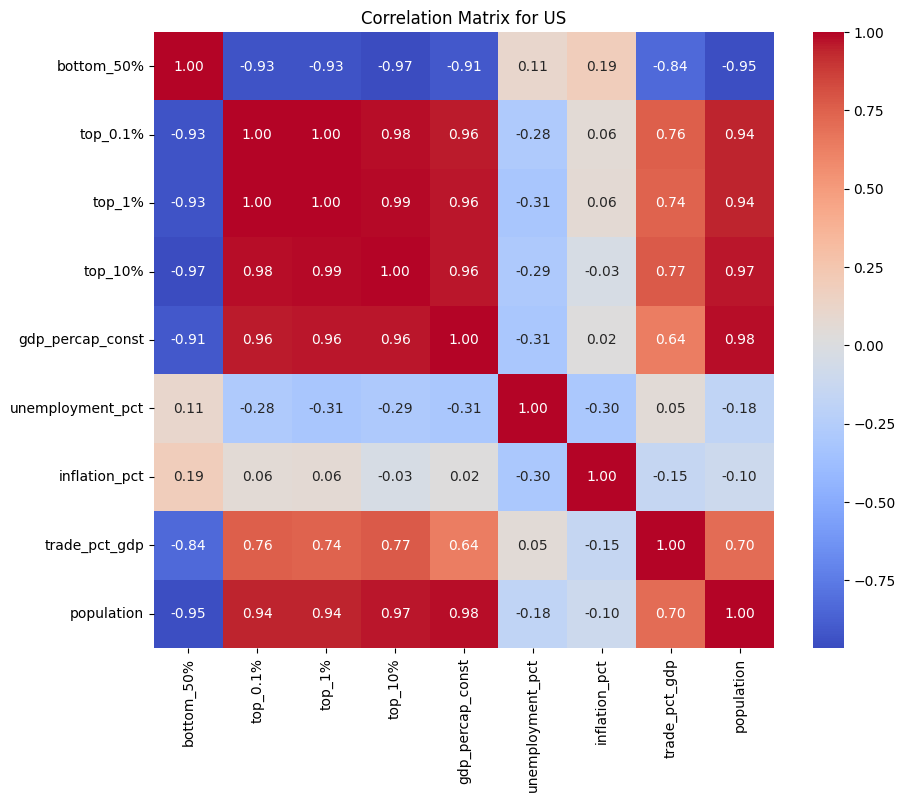

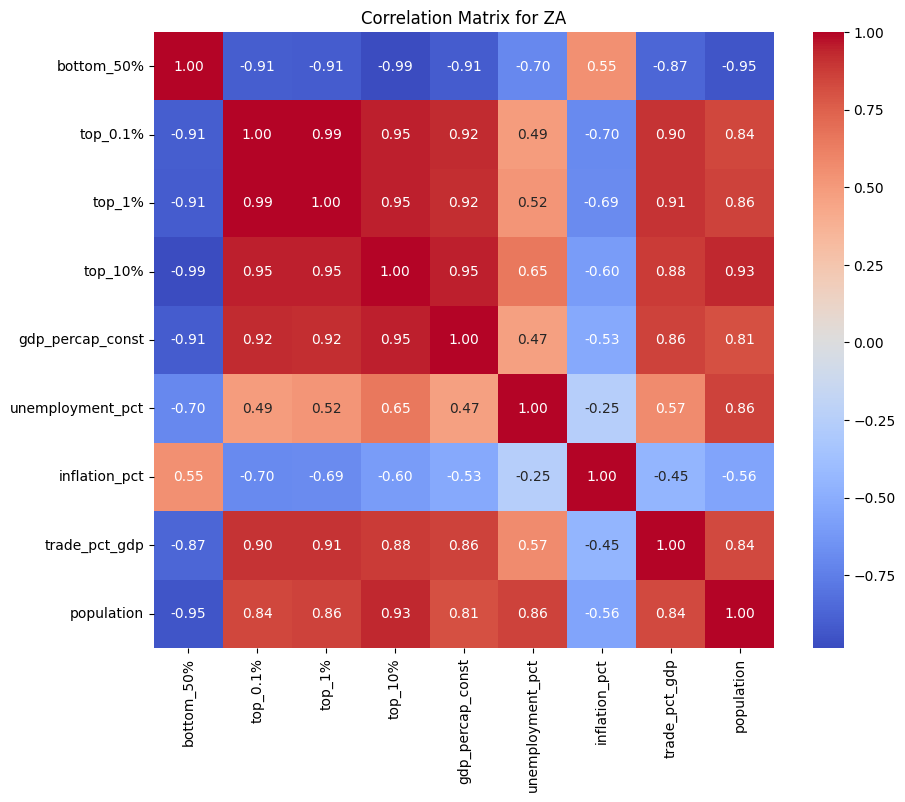

In [90]:
import matplotlib.pyplot as plt

# plot correlation matrix for all the features
import seaborn as sns

for code in df_merge['country_code'].unique():
    country_data = df_merge[df_merge['country_code'] == code]
    df_corr = country_data.drop(columns=['country_code', 'year', 'country']) # Drop non-numeric columns for correlation
    # plot correlation matrix for all the features
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title(f'Correlation Matrix for {code}')
    plt.show()

